[View in Colaboratory](https://colab.research.google.com/github/chanthony/IndiaAgriculture/blob/master/Agriculture.ipynb)

# Introduction

Computer science and data science in particular has spread into many fields and aspects of life. One of the aspects which has not had much exposure to data science is agriculture. In this project we attempted to apply data science to better understand agriculture and in particular the production of cereals. 

Cereals are what consumers usually think of as grains such as wheat, rice, or even corn. This family of crops makes up a significant portion of food consumption around the world as well as having applications such as ethanol production. Their prevalence in our daily lives is part of what makes study about their production so interesting.

In this project we attempted to build a predictive model to take in various aspects of a countries agricultural industry and predict cereal production for that country. By studying these models we can start to make some observations regarding how these aspects relate to agriculture

# Data Set

For this project we used data  from the World Bank as part of their World Development Indicators data set. You can explore that dataset on your own [here](http://databank.worldbank.org/data/reports.aspx?source=world-development-indicators). The data set has over 1500 different features for 241 countries stretching as far back as 1960. These features describe the countries in many aspects ranging from the economy to environmental characteristics. For this data set we selected a subset of variables to consider that pertained to agriculture.

Each row in the dataframe is the value for a given indicator for a specific country and year combination. The columns are the country code, the year, and the indicator code as well as the value for the given indicator. Since we are predicting for each country we will need to transform the data set so country year combinations are combined into a single row rather than split across multiple rows.

# Libaries

This project relies upon the support of a few libraries to make everything work.

The data file we used is stored in a csv. To get that file we use `requests` and we use `io` to process it

In [0]:
import requests
import io

To help manage all of our data we use pandas dataframes.

In [0]:
import pandas as pd

For dealing with the the mathematical portion of our calculations as well as matrix calculations we use numpy

In [0]:
import numpy as np

For our models we use an sklearn backend. Each model is imported seperately for clarity.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

from sklearn import feature_selection

from sklearn.linear_model import LinearRegression as sklr

#Support Vector Regression
from sklearn.svm import SVR

And finally for data visualization we used matplotlib.

In [0]:
import matplotlib.pyplot as plt

# DELETE THIS NEXT PART
Importing the files from google drive will not be necessary when submitting the file

## Import File

The code below is used to import the csv file from google drive. The code should work as long as the indicators.csv file is either on your google drive or shared with your account. If it is on your google drive you have to make sure the file id in CreateFile is correct

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2. Get the file
downloaded = drive.CreateFile({'id':'1tamVVMEyXlOm0I7oq9eFqdUh1bJ6DVzu'}) # replace the id with id of file you want to access
downloaded.GetContentFile('indicators.csv')  

# Reading and Formatting the Data Frame

To start we read in the data from a csv file called `indicators.csv`

In [16]:
#Read in data frame
url="https://raw.githubusercontent.com/cs109/2014_data/master/countries.csv"
s = requests.get(url).content
indicators = =pd.read_csv(io.StringIO(s.decode('utf-8')))
indicators = pd.read_csv('indicators.csv', sep = ',')
indicators.head(9)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06
5,Arab World,ARB,Arms imports (SIPRI trend indicator values),MS.MIL.MPRT.KD,1960,5.380000e+08
6,Arab World,ARB,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,1960,4.769789e+01
7,Arab World,ARB,CO2 emissions (kt),EN.ATM.CO2E.KT,1960,5.956399e+04
8,Arab World,ARB,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1960,6.439635e-01


## Extract the relevant rows

Now that we have the dataframe we select the indicators. We preselected a set of indicators relevant to agriculture. We begin by putting our selected variables into a dictionary with the key being the human readable name for the indicator and the value being the indicator code used by the dataset.

In [0]:
#Select only relevant indicators
ag_indicators = {
    'ag machinery, tractors':'AG.AGR.TRAC.NO',
    'ag machinery per 100 sq km':'AG.LND.TRAC.ZS',
    'ag value added per worker':'EA.PRD.AGRI.KD',
    'cereal production, tons':'AG.PRD.CREL.MT',
    'cereal yield, kg per hectare':'AG.YLD.CREL.KG',
    'fertilizer consumption, % (quantity used per unit of arable land)':'AG.CON.FERT.PT.ZS',
    'fertilizer consumption, kg per hectare of arable land':'AG.CON.FERT.ZS',
    'land under cereal production, hectare':'AG.LND.CREL.HA',
    'ag irrigated land, %':'AG.LND.IRIG.AG.ZS',
    'ag total land, %':'AG.LND.AGRI.ZS',
    'ag total land, sq km':'AG.LND.AGRI.K2',
    'arable land, %':'AG.LND.ARBL.ZS',
    'arable land, hectares':'AG.LND.ARBL.HA',
    'average precipitation, mm per year':'AG.LND.PRCP.MM',
    'land area, sq km':'AG.LND.TOTL.K2',
    'permanent cropland, %':'AG.LND.CROP.ZS',
    'food production index':'AG.PRD.FOOD.XD',
    'value added agriculture':'NV.AGR.TOTL.KD'
}    


Now that we have defined what indicators we want to select we run through our data and select only the rows which have indicator codes matching the ones in our dictionary. We then store these in a dictionary where the key is the indicator code and the value is all the relevant rows.

In [0]:

#Formatted as a dict keyed by indicator code
#Each value is a dataframe containing the rows relevant to the indicator split by country and year
agDF = {}
keys = []
values = []
for key, value in ag_indicators.items():
    rows = indicators.loc[indicators['IndicatorCode'] == value][['CountryCode', 'Year', 'Value']]
    keys.append(key)
    values.append(rows)
    agDF[key] = rows 

In addition to the features built into the table, we define an additional feature corresponding to the raw fertilizer consumption by country.

In [0]:

#Calculate total fertilizer used
fertilizer = clean(['fertilizer_consumption', 'arable_land'],
                    agDF['fertilizer consumption, kg per hectare of arable land'],
                    agDF['arable land, hectares'])
fertilizer['Value'] = fertilizer.fertilizer_consumption * fertilizer.arable_land
fertilizer.drop(['fertilizer_consumption','arable_land'],axis=1,inplace=True)

agDF['fertilizer'] = fertilizer


##Format the indicators into one data frame

This part is actually jumpting ahead a little bit but it's easier to solve now than later. The countries in the data set aren't strictly countries. Some of the "countries" are actually regions. The problem that arises is that countries end up getting double counted whihc in some cases can skew our results. As such when we collect our data set we preemptively remove the non-country countries. 

In [0]:
regions = ['ARB','CSS','EAS','EAP','ECS','ECA','EUU','FCS','HPC','HIC','NOC','OEC','LCN',
           'LAC','LDC','LMY','LIC','LMC','MEA','MNA','MIC','NAC','MNP','OED','OSS','PSS',
           'SST','SAS','ZAF','SSF','SSA','UMC','WLD']


We define a helpre function we refer to as `clean`. This function takes in the column names and a series of data frames corresponding to the different indicators. These frames are merged together by the country code and year. By the time this is done we should have a data frame where each row is a country/year pair and the columns are the features we selected.

In [0]:
"""
clean: Formats the frames given in df1 and *data to make a single data frame
input: list of string + dataframe
names: column names for given columns in order
output: dataframe in format: CountryCode, year, indicators**
"""
def clean(names, df1, *data):
    n = 0
    df = df1.copy()
    if 'Value' in df1.columns.values:
        df.rename(columns={'Value':names[n]}, inplace=True)
        n += 1
    for f in data:
        frame = f.copy()
        if 'Value' in frame.columns.values:
            frame.rename(columns={'Value':names[n]}, inplace=True)
            n += 1
        df = pd.merge(df, frame, how='left', on=['CountryCode','Year'])
    # Necessary to remove the double-counting regions noted in the first section
    for name in regions:
        df.drop(df.loc[df.CountryCode == name].index, inplace=True)
    return df


We actually build two versions of our data frame. The first is using a smaller subset of the variables selected via inuition. This data frame is simply named  `df`. The second data frame contains all of the variables relevant to agriculture(although a few are removed due to only containing a few hundred samples). This second data frame we will later use to feed into feature selection to compare to our intuition.

For both data frames we drop the country code and year for two reasons. The first reason is that we simply no longer need them. None of our models are cluster based or otherwise rely on knowing the labels. The second reasons is that non-numeric features get in the way of any mathematical calculations done on the data frames so it is simply easier to just remove them.

In [23]:

df = clean(
    ["cereal production", 'tractors', 'fertilizer', 'average precipitation', 'land under cereal production',
     'ag total land', 'arable land', 'land area'],
    agDF['cereal production, tons'],
    agDF['ag machinery, tractors'],
    agDF['fertilizer'],
    agDF['average precipitation, mm per year'],
    agDF['land under cereal production, hectare'],
    agDF['ag total land, sq km'],
    agDF['arable land, hectares'],
    agDF['land area, sq km']
)

df_full = clean(keys,
          *values)

df_full = df_full.drop(['CountryCode', 'Year', 'fertilizer consumption, % (quantity used per unit of arable land)',
             'fertilizer consumption, kg per hectare of arable land', 'ag irrigated land, %'], axis = 1)

df = df.drop(['CountryCode','Year'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8686 entries, 2 to 10381
Data columns (total 8 columns):
cereal production               8686 non-null float64
tractors                        5574 non-null float64
fertilizer                      1787 non-null float64
average precipitation           1744 non-null float64
land under cereal production    8686 non-null float64
ag total land                   8672 non-null float64
arable land                     8566 non-null float64
land area                       8686 non-null float64
dtypes: float64(8)
memory usage: 610.7 KB


In [24]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6086 entries, 4 to 7243
Data columns (total 15 columns):
ag machinery, tractors                   6086 non-null float64
ag machinery per 100 sq km               6035 non-null float64
ag value added per worker                2318 non-null float64
cereal production, tons                  5574 non-null float64
cereal yield, kg per hectare             5484 non-null float64
land under cereal production, hectare    5574 non-null float64
ag total land, %                         6086 non-null float64
ag total land, sq km                     6086 non-null float64
arable land, %                           6035 non-null float64
arable land, hectares                    5974 non-null float64
average precipitation, mm per year       1161 non-null float64
land area, sq km                         6086 non-null float64
permanent cropland, %                    5819 non-null float64
food production index                    6064 non-null float64
value added

## Imputation

As can be seen in the data summaries from the previous sections, some of the indicators are rather sparse. In particular, average participation and fertilizer usage both have around 1750 non null rows. To help correct that, we use regression imputation to help fill in some of these non null values.

Essentially, we train a regression model on the rows for which the given indicator is defined and then use that model to predict the values for the rows where the indicator is not defined.

In [7]:
def contains_nan(row):
  return pd.isnull(row).any()

def imputate(df, label):
  train = df.loc[pd.isnull(df[label]) == False]
  
  cols = list(train.columns.values)
  cols.remove(label)
  
  train = train.dropna(axis = 0, how = 'any', subset = cols)
  
  train_y = train[label]
  train_x = train.drop(label, axis = 1)
  
  regr = sklr()
  
  model = regr.fit(train_x, y = train_y)
  
  def f(x):
    x_param = x[:]
    x_param = x_param.drop(label)
    
    if(pd.isnull(x[label]) and not contains_nan(x_param)):
      return model.predict(x_param.values.reshape(1,-1))
    else:
      return x[label]
  
  df[label] = df.apply(f, axis = 1)

  return df
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8569 entries, 2 to 10381
Data columns (total 8 columns):
cereal production               8569 non-null float64
tractors                        5830 non-null object
fertilizer                      2777 non-null object
average precipitation           1937 non-null object
land under cereal production    8569 non-null float64
ag total land                   8555 non-null float64
arable land                     8449 non-null float64
land area                       8569 non-null float64
dtypes: float64(5), object(3)
memory usage: 602.5+ KB


Since imputation only works for rows where every indicator except the one being targeted is non-null, this greatly restricts the number of rows we can fill in at a time. The main problem is that `fertilizer` and `average precipitation` are both very sparse and have little overlap. In fact, the number of rows in the initial data set where both are non-null is only 88. To fix that, we alternate between imputating over the two indicators over and over again to slowly fill in the data set.  

In [0]:

#Upping this count to 40 creates no significant improvement
for i in range(10):
  df = imputate(df, 'average precipitation')
  df = imputate(df, 'fertilizer')

df = imputate(df, 'tractors')

df.info()

In [0]:
for i in range(10):
  for i in range(10):
    df_test = imputate(df_test, 'average precipitation, mm per year')
    df_test = imputate(df_test, 'ag value added per worker')

  df_test = imputate(df_test, 'value added agriculture')

### Data Filtering

In [16]:
df = df.dropna(axis = 0, how = 'any')

df.shape

(1661, 8)

## Feature Selection

#### Using SelectKBest

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2348 entries, 219 to 7243
Data columns (total 15 columns):
ag machinery, tractors                   2348 non-null float64
ag machinery per 100 sq km               2348 non-null float64
ag value added per worker                2348 non-null object
cereal production, tons                  2348 non-null float64
cereal yield, kg per hectare             2348 non-null float64
land under cereal production, hectare    2348 non-null float64
ag total land, %                         2348 non-null float64
ag total land, sq km                     2348 non-null float64
arable land, %                           2348 non-null float64
arable land, hectares                    2348 non-null float64
average precipitation, mm per year       2348 non-null object
land area, sq km                         2348 non-null float64
permanent cropland, %                    2348 non-null float64
food production index                    2348 non-null float64
value added

In [22]:
fs = feature_selection.SelectKBest(k = 4)

df_test = df_test.dropna(axis = 0, how = 'any')

df_y = df_test['cereal production, tons']
df_x = df_test.drop('cereal production, tons', axis = 1)
print(list(df_x.columns.values))

fs.fit(df_x, df_y)
print(fs.get_support())
print(np.array(df_x.columns.values)[np.array(fs.get_support())])

['ag machinery, tractors', 'ag machinery per 100 sq km', 'ag value added per worker', 'cereal yield, kg per hectare', 'land under cereal production, hectare', 'ag total land, %', 'ag total land, sq km', 'arable land, %', 'arable land, hectares', 'average precipitation, mm per year', 'land area, sq km', 'permanent cropland, %', 'food production index', 'value added agriculture']
[ True False False False  True False False False  True False False False
 False  True]
['ag machinery, tractors' 'land under cereal production, hectare'
 'arable land, hectares' 'value added agriculture']


With k = 4,SelectKBest selects tractors, land under cereal production, arable land, and land area as the k features
With k = 3, land area gets dropped

#### Using Recursive Feature Elimination


In [45]:
reg = sklr(normalize = True)

rfe = feature_selection.RFECV(estimator = reg, scoring = 'r2')

rfe.fit(df_x, df_y)

rfe.n_features_

print(np.array(df_x.columns.values)[np.array(rfe.get_support())])
selected = np.array(df_x.columns.values)[np.array(rfe.get_support())]

['ag machinery, tractors' 'ag machinery per 100 sq km'
 'ag value added per worker' 'cereal yield, kg per hectare'
 'land under cereal production, hectare' 'ag total land, %'
 'ag total land, sq km' 'arable land, %'
 'average precipitation, mm per year' 'land area, sq km'
 'permanent cropland, %' 'food production index']


### Split dataframe into train/test

In [48]:
train, test = sk.model_selection.train_test_split(df, test_size = 0.2)

train.head()

,cereal production,tractors,average precipitation,land under cereal production,ag total land,arable land,land area
2170,16912500.0,115606.0,637.0,6238400.0,149430.0,9713000.0,230340.0
3973,2065900.0,29956.0,216.0,2355875.0,94500.0,5250000.0,437370.0
5928,3179.0,174.0,78.0,1373.0,3390.0,38000.0,83600.0
346,2238756.0,5591.0,252.0,2268047.0,149700.0,6200000.0,183780.0
1249,855300.0,250.0,686.0,1344165.0,89470.0,3232000.0,192530.0


## Linear Regression Model

In [0]:
train_y = train['cereal production']

train_x = train.drop( 'cereal production', axis = 1)
train_x = preprocessing.scale(train_x)

In [19]:
score = []
mse = []


best_pred = []
best_score = 0

for x in range(1000):
  train, test = sk.model_selection.train_test_split(df, test_size = 0.2)

  
  train_y = train['cereal production']
  train_x = train.drop( 'cereal production', axis = 1)
  
  test_y = train['cereal production']
  test_x = train.drop( 'cereal production', axis = 1)
  
  regr = sklr(normalize = True)
  
  regr.fit(train_x, train_y)
  
  pred = regr.predict(test_x)
  score.append(regr.score(test_x,test_y))
  
  if(regr.score(test_x,test_y) > best_score):
    best_pred = pred
    best_real = test_y
  
  mse.append(metrics.mean_squared_error(test_y, pred))
  
  
print("R-Squared:    {0} \n"
      "Mean-Squared: {1}".format(np.mean(score),np.mean(mse)))

R-Squared:    0.9690115588811243 
Mean-Squared: 62596601420559.0


### Real Vs. Predicted

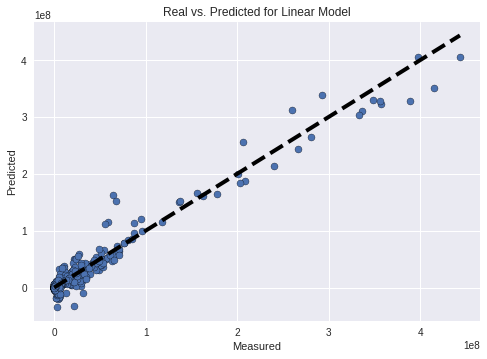

In [21]:
fig, ax = plt.subplots()
ax.scatter(best_real, best_pred, edgecolors=(0, 0, 0))
ax.plot([best_real.min(), best_real.max()], [best_real.min(), best_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Real vs. Predicted for Linear Model')
plt.show()

## Regression With Feature Selection

In [46]:
score = []
mse = []


best_pred = []
best_score = 0

selected = selected.tolist()
selected.append('cereal production, tons')
df_selected = df_test[selected] 

df_selected = df_selected.dropna(axis = 0, how = 'any')

for x in range(1000):
  train, test = sk.model_selection.train_test_split(df_selected, test_size = 0.2)

  
  train_y = train['cereal production, tons']
  train_x = train.drop( 'cereal production, tons', axis = 1)
  
  test_y = train['cereal production, tons']
  test_x = train.drop( 'cereal production, tons', axis = 1)
  
  regr = sklr(normalize = True)
  
  regr.fit(train_x, train_y)
  
  pred = regr.predict(test_x)
  score.append(regr.score(test_x,test_y))
  
  if(regr.score(test_x,test_y) > best_score):
    best_pred = pred
    best_real = test_y
  
  mse.append(metrics.mean_squared_error(test_y, pred))
  
  
print("R-Squared:    {0} \n"
      "Mean-Squared: {1}".format(np.mean(score),np.mean(mse)))

R-Squared:    0.8917087848614822 
Mean-Squared: 250268130836925.94


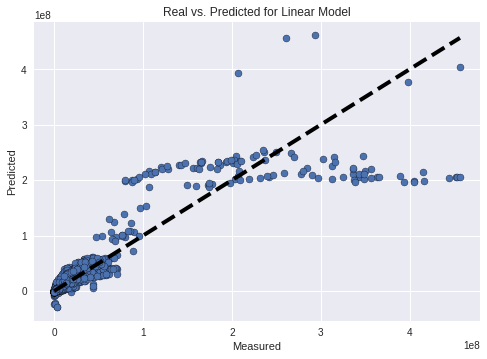

In [26]:
ig, ax = plt.subplots()
ax.scatter(best_real, best_pred, edgecolors=(0, 0, 0))
ax.plot([best_real.min(), best_real.max()], [best_real.min(), best_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Real vs. Predicted for Linear Model')
plt.show()

## Support Vector Regression(SVR)

In [1]:
score = []
mse = []

for x in range(1000):
  train, test = train_test_split(df, test_size = 0.2)

  train_y = train['cereal production']
  train_x = train.drop( 'cereal production', axis = 1)
  
  test_y = train['cereal production']
  test_x = train.drop( 'cereal production', axis = 1)
  
  regr = SVR(C = 10, epsilon = 0.2, degree = 6)
  
  regr.fit(train_x, train_y)
  
  pred = regr.predict(test_x)
  score.append(regr.score(test_x,test_y))
  mse.append(metrics.mean_squared_error(test_y, pred))
  
  
print("R-Squared:    {0} \n"
      "Mean-Squared: {1}".format(np.mean(score),np.mean(mse)))

NameError: ignored